# The polyhedral gravity model - Python interface

First some imports:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib import cm
import polyhedral_gravity as gravity_model
%matplotlib inline

## The gravity tensor of a cube

Next, we start with an easy example evaluating the gravity tensor for points of a cubic polyhedron consisting of $12$ triangular faces, centered at the origin $(0, 0, 0)$ and with edges of $2m$.
Therefor, we first declare the vertices and the connectivity of this polyhedron.

**Important!:** The vertices in the faces need to be sorted, so that the plane normals will point outwards of the polyhedron!

In [2]:
cube_vertices = np.array([
    [-1, -1, -1],
    [1, -1, -1],
    [1, 1, -1],
    [-1, 1, -1],
    [-1, -1, 1],
    [1, -1, 1],
    [1, 1, 1],
    [-1, 1, 1]
])

cube_faces = np.array([
    [1, 3, 2],
    [0, 3, 1],
    [0, 1, 5],
    [0, 5, 4],
    [0, 7, 3],
    [0, 4, 7],
    [1, 2, 6],
    [1, 6, 5],
    [2, 3, 6],
    [3, 7, 6],
    [4, 5, 6],
    [4, 6, 7]
])

Next we define the wished computation point $(1, 0, 0)$ and the density in $\frac{kg}{m^3}$

In [3]:
computation_point = [1, 0, 0]
density = 1.0 # kg/m^3

Then, we evaluate the gravity tensor. As a result, we get the potential in $\frac{J}{kg}$, the acceleration in the three cartesian directions in $\frac{m}{s^2}$ and the second derivatives in $\frac{1}{s^2}$

In [4]:
potential, acceleration, tensor = gravity_model.evaluate(cube_vertices, cube_faces, density, computation_point)

print("=============Gravity Model Solution=============")
print("Potential: {} m^2/s^2".format(potential))
print("Acceleration [Vx, Vy, Vz]: {} m/s^2".format(acceleration))
print("Second derivative tensor [Vxx, Vyy, Vzz, Vxy, Vxz, Vyz]: {} 1/s^2".format(tensor))

=============Gravity Model Solution=============
Potential: 4.786301362419239e-10 m^2/s^2
Acceleration [Vx, Vy, Vz]: [3.466493366453959e-10, 0.0, 0.0] m/s^2
Second derivative tensor [Vxx, Vyy, Vzz, Vxy, Vxz, Vyz]: [-5.375692682923615e-11, -1.8280085506392544e-10, -1.8280085506392544e-10, 0.0, 0.0, 0.0] 1/s^2


Further, we can compare our solution to analytical solution. Here the following integral needs to be computed for a point with the coordinates $(X, Y, Z)$:

$V(X, Y, Z) = -G \rho \cdot \int_{-1}^{1} \int_{-1}^{1} \int_{-1}^{1} \frac{dx'dy'dz'}{\sqrt{((X-x')^2 + (Y-y')^2 + (Z-z')^2}}$

TODO: Ask why multiply with $-1$? --> Should the model do this too?

We can here calculate the analytical solutions by using the transformations of _CHAPPELL, James M., et al. The gravitational field of a cube. arXiv preprint arXiv:1206.3857, 2012._ and the power of `sympy`.

In [5]:
import analytical_cube_gravity

analytical_potential = analytical_cube_gravity.evaluate_potential(*computation_point)
analytical_acceleration = np.array(analytical_cube_gravity.evaluate_acceleration(*computation_point))

print("=============Analytical Solutions=============")
print("Analytical Potential: {} m^2/s^2".format(analytical_potential))
print("Analytical Acceleration [Vx, Vy, Vz]: {} m/s^2".format(analytical_acceleration))
print("=================Differences==================")
print("Difference Potential: {}".format(abs(analytical_potential - potential)))
print("Difference Acceleration: {}".format(abs(analytical_acceleration - np.array(acceleration))))

=============Analytical Solutions=============
Analytical Potential: 4.78630136241924E-10 m^2/s^2
Analytical Acceleration [Vx, Vy, Vz]: [3.46649336645396e-10 0 0] m/s^2
=================Differences==================
Difference Potential: 2.06795153138257E-25
Difference Acceleration: [1.55096364853693e-25 0 0]


Plotting the above described triangulation of the cube:

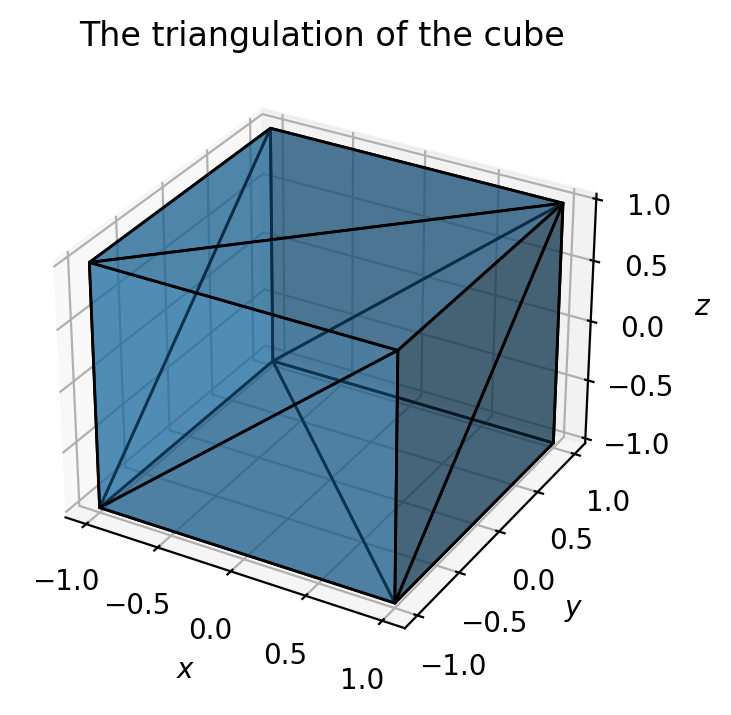

In [6]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

ax.plot_trisurf(cube_vertices[:,0], cube_vertices[:,1], cube_vertices[:,2], triangles = cube_faces, edgecolor=[[0,0,0]], linewidth=1.0, alpha=0.5)

fig.set_dpi(200)

ax.set_title("The triangulation of the cube")
ax.set_xlabel("$x$")
ax.set_ylabel("$y$")
ax.set_zlabel("$z$")

plt.show()

Evaluating the model for multiple points at once around the cube:

In [7]:
X = np.arange(-2, 2.01, 0.01)
Y = np.arange(-2, 2.01, 0.01)

computation_points = np.array(np.meshgrid(X, Y, [0])).T.reshape(-1, 3)
gravity_results = gravity_model.evaluate(cube_vertices, cube_faces, density, computation_points)

Plotting the potential for the cube for the layer $(x, y, 0)$ with $x, y \in \mathbb{R}$

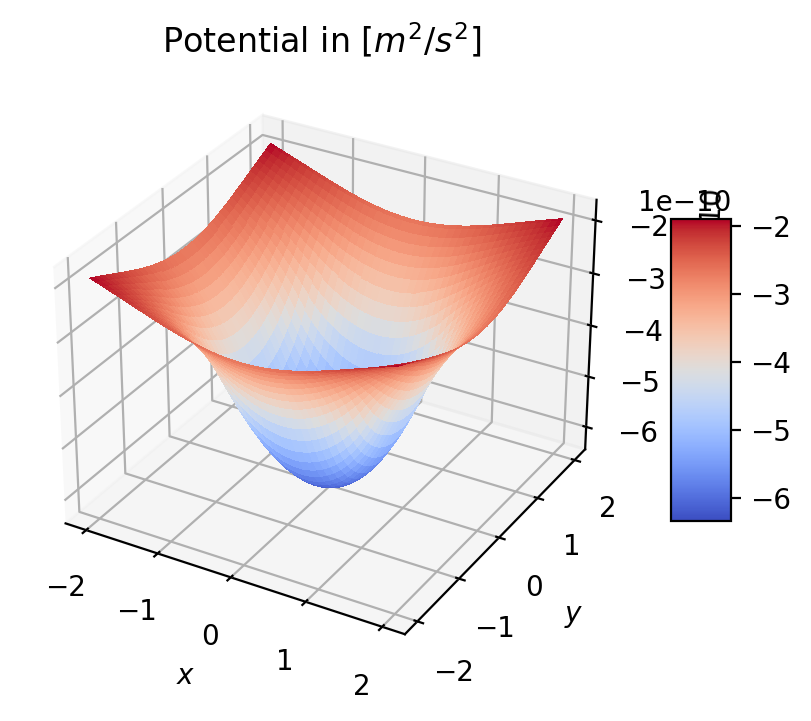

In [8]:
# Extracting the potential from our result
potentials = np.array([i[0] for i in gravity_results])

# TODO: Ask why?
potentials = -1 * potentials

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

# Make data.
X, Y = np.meshgrid(X, Y)
Z = potentials.reshape((len(X), len(Y)))

# Plot the surface.
surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

ax.set_title("Potential in [$m^2/s^2$]")

ax.set_xlabel("$x$")
ax.set_ylabel("$y$")

# Add a color bar which maps values to colors.
fig.colorbar(surf, aspect=5, orientation='vertical', shrink=0.5)

fig.set_dpi(200)

plt.show()

Now, let's plot the acceleration in  $x$ and $y$ directions. One should see the distortion of the streamlines at the edges of the cube.

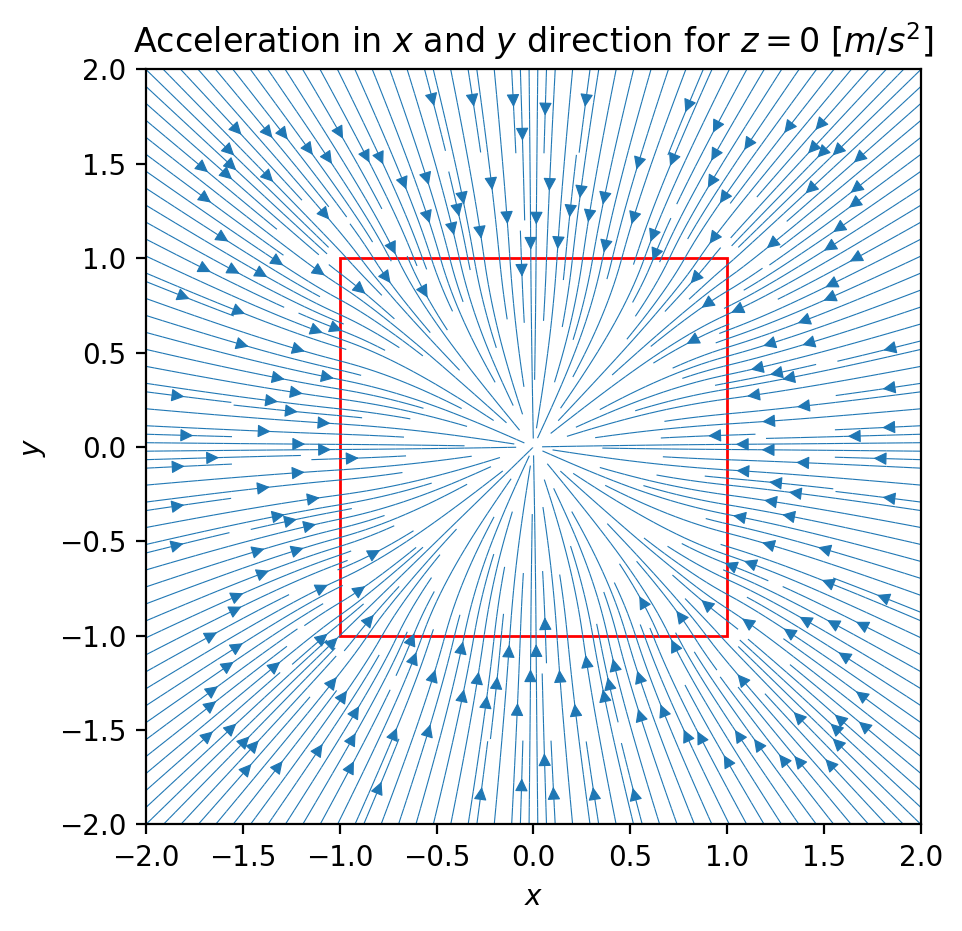

In [9]:
# We just want a slice of x, y values for z = 0
accelerations = np.array([i[1][:] for i in gravity_results])
accelerations = np.delete(accelerations, 2, 1)

# TODO: Ask why?
accelerations = -1 * accelerations


fig, ax = plt.subplots()

U = np.reshape(accelerations[:, 0], (len(X), -1))
V = np.reshape(accelerations[:, 1], (len(Y), -1))

# Quiver Plot the surface!!!! X <--> Y reversed! Investigate why?
# Streamplot --> X, Y ok, but V <--> U reversed?
plt.streamplot(X, Y, V, U, density=3, linewidth=0.4)

rect = patches.Rectangle((-1, -1), 2, 2, linewidth=1, edgecolor='r', facecolor='none')

# Add the patch to the Axes
ax.add_patch(rect)

ax.set_title("Acceleration in $x$ and $y$ direction for $z=0$ $[m/s^2]$")
ax.set_xlabel("$x$")
ax.set_ylabel("$y$")

fig.set_dpi(200)
fig.set_size_inches((5, 5))

plt.show()

## Next some bigger example: Eros

Here, we can test the convenient feature of giving file input to the polyhedral gravity model's Python interface.
Further, the units are not correct, since the mesh size in unknown.

**Important Note:** If the polyhedron is located in two files (like for .node and .face files), the node files needs to be placed first in the list! If it is just a single file (e.g. .ply), then list just contains this single element.

In [10]:
eros_vertices_path = "mesh/Eros.node"
eros_faces_path = "mesh/Eros.face"

density = 2670.0 # kg/m^3
computation_point = np.array([0, 0, 0])

potential, acceleration, tensor = gravity_model.evaluate([eros_vertices_path, eros_faces_path], density, computation_point)

print("Potential: {} m^2/s^2".format(potential))
print("Acceleration [Vx, Vy, Vz]: {} m/s^2".format(acceleration))
print("Second derivative tensor [Vxx, Vyy, Vzz, Vxy, Vxz, Vyz]: {} 1/s^2".format(tensor))

Potential: 1.6412193813901066e-07 m^2/s^2
Acceleration [Vx, Vy, Vz]: [2.4104224440050168e-09, 3.910184096846771e-08, 9.0390234517644e-09] m/s^2
Second derivative tensor [Vxx, Vyy, Vzz, Vxy, Vxz, Vyz]: [-1.224392128772978e-07, -1.1414944948899535e-06, -9.754414135835885e-07, -3.8638148702275724e-08, 1.3548134599040798e-08, -2.6597490639599456e-08] 1/s^2


Of course again, we can also give an array of points to the calculation to evaluate the gravity model for multiple points at once.

In [11]:
X = np.arange(-1.0, 1.05, 0.05)
Y = np.arange(-1.0, 1.05, 0.05)

computation_points = np.array(np.meshgrid(X, Y, [0])).T.reshape(-1, 3)
gravity_results = gravity_model.evaluate([eros_vertices_path, eros_faces_path], density, computation_points)

Plotting the potential for Eros:

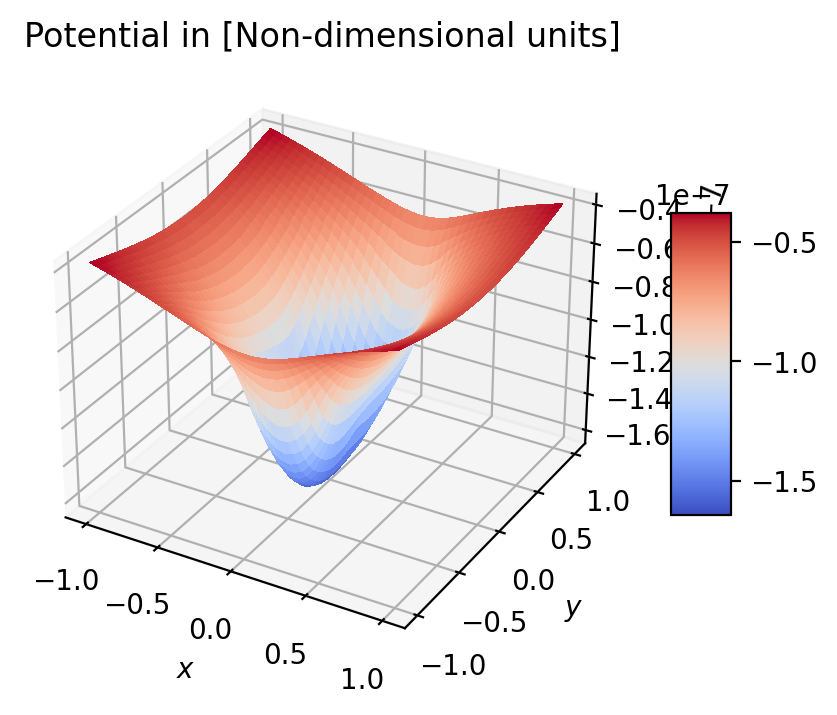

In [12]:
# Extracting the potential from our result
potentials = np.array([i[0] for i in gravity_results])

# TODO: Ask why?
potentials = -1 * potentials

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

# Make data.
X, Y = np.meshgrid(X, Y)
Z = potentials.reshape((len(X), len(Y)))

# Plot the surface.
surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

ax.set_title("Potential in [Non-dimensional units]")

ax.set_xlabel("$x$")
ax.set_ylabel("$y$")

# Add a color bar which maps values to colors.
fig.colorbar(surf, aspect=5, orientation='vertical', shrink=0.5)

fig.set_dpi(200)

plt.show()

And the acceleration for the slice with $z = 0$:

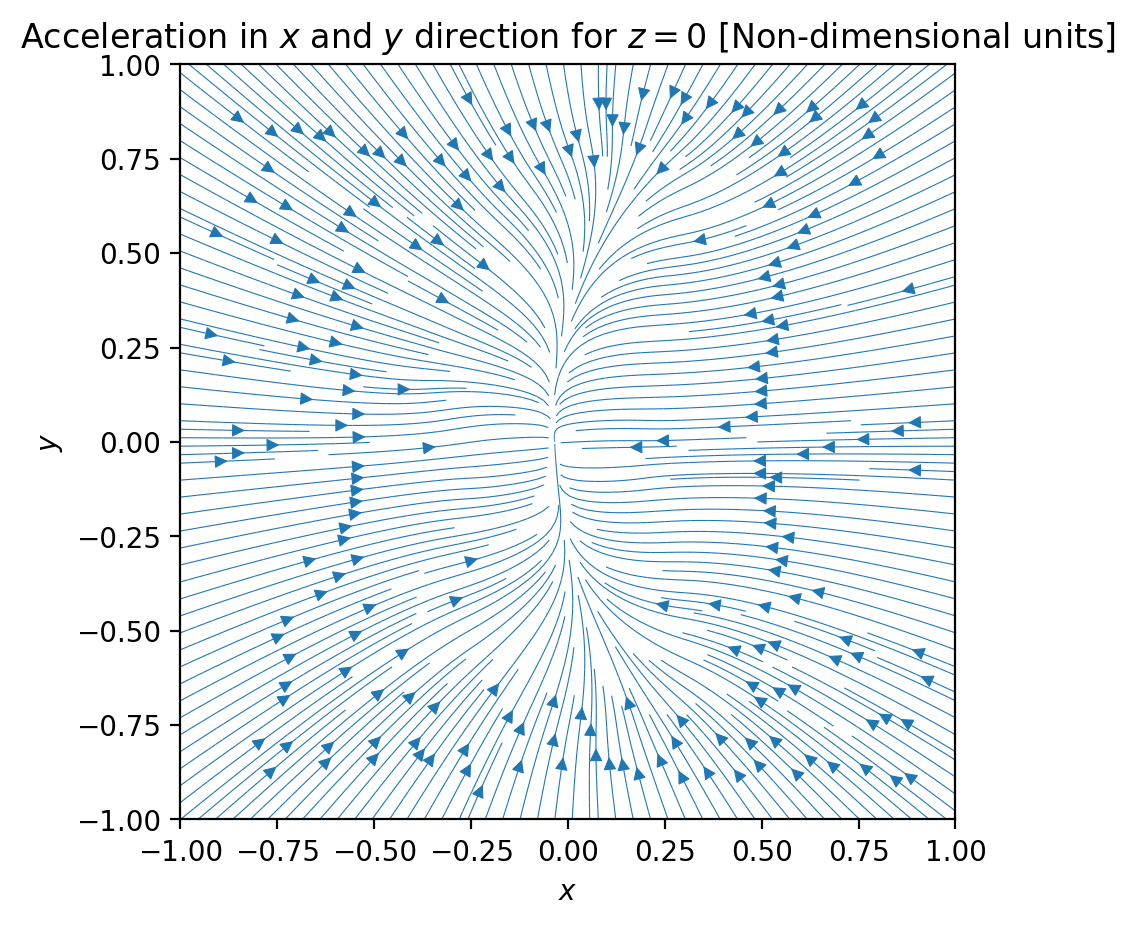

In [13]:
# We just want a slice of x, y values for z = 0
accelerations = np.array([i[1][:] for i in gravity_results])
accelerations = np.delete(accelerations, 2, 1)

# TODO: Ask why?
accelerations = -1 * accelerations


fig, ax = plt.subplots()

U = np.reshape(accelerations[:, 0], (len(X), -1))
V = np.reshape(accelerations[:, 1], (len(Y), -1))

# Quiver Plot the surface!!!! X <--> Y reversed! Investigate why?
# Streamplot --> X, Y ok, but V <--> U reversed?
plt.streamplot(X, Y, V, U, density=3, linewidth=0.4)

ax.set_title("Acceleration in $x$ and $y$ direction for $z=0$ [Non-dimensional units]")
ax.set_xlabel("$x$")
ax.set_ylabel("$y$")

fig.set_dpi(200)
fig.set_size_inches((5, 5))

plt.show()

# Next example: Torus

Here, we use some additional utility to read in the vertices and triangles from the `.pk` file since this file format is not directly supported through the python interface. Additionally, we can plot the Torus, since we have the "raw" vertices and faces directly in Python.

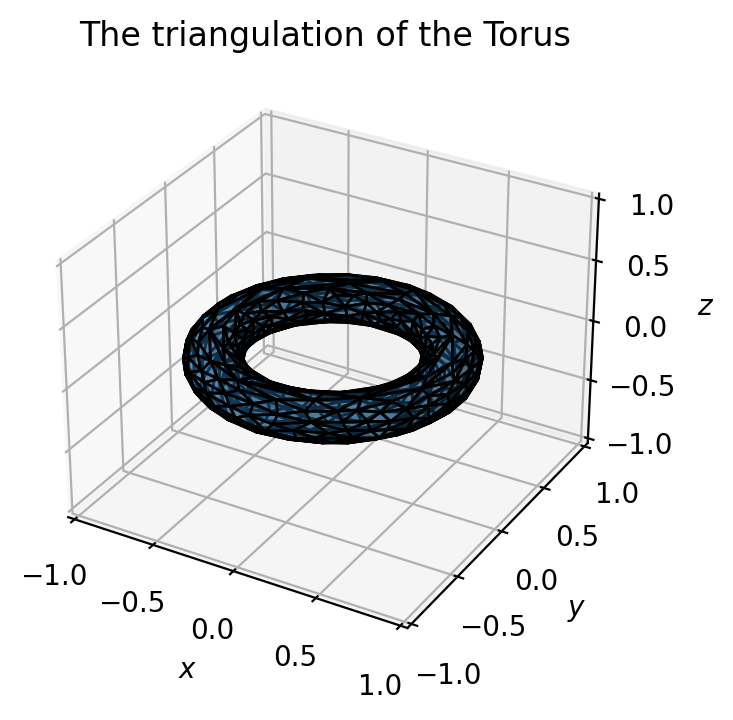

In [14]:
import mesh_utility

torus_vertices, torus_faces = mesh_utility.read_pk_file("mesh/torus_lp.pk")

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

ax.plot_trisurf(torus_vertices[:,0], torus_vertices[:,1], torus_vertices[:,2], triangles = torus_faces, edgecolor=[[0,0,0]], linewidth=1.0, alpha=0.5)

fig.set_dpi(200)

ax.set_xlim(-1, 1)
ax.set_ylim(-1, 1)
ax.set_zlim(-1, 1)

ax.set_title("The triangulation of the Torus")
ax.set_xlabel("$x$")
ax.set_ylabel("$y$")
ax.set_zlabel("$z$")

plt.show()

In [15]:
X = np.arange(-1.0, 1.05, 0.01)
Y = np.arange(-1.0, 1.05, 0.01)

computation_points = np.array(np.meshgrid(X, Y, [0])).T.reshape(-1, 3)
gravity_results = gravity_model.evaluate(torus_vertices, torus_faces, density, computation_points)

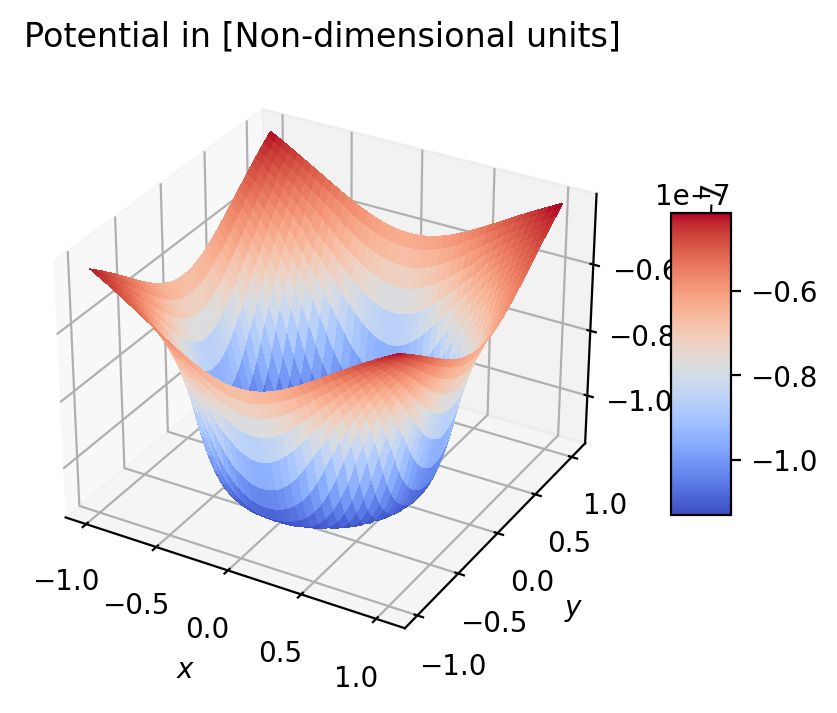

In [16]:
# Extracting the potential from our result
potentials = np.array([i[0] for i in gravity_results])

# TODO: Ask why?
potentials = -1 * potentials

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

# Make data.
X, Y = np.meshgrid(X, Y)
Z = potentials.reshape((len(X), len(Y)))

# Plot the surface.
surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

ax.set_title("Potential in [Non-dimensional units]")

ax.set_xlabel("$x$")
ax.set_ylabel("$y$")

# Add a color bar which maps values to colors.
fig.colorbar(surf, aspect=5, orientation='vertical', shrink=0.5)

fig.set_dpi(200)

plt.show()

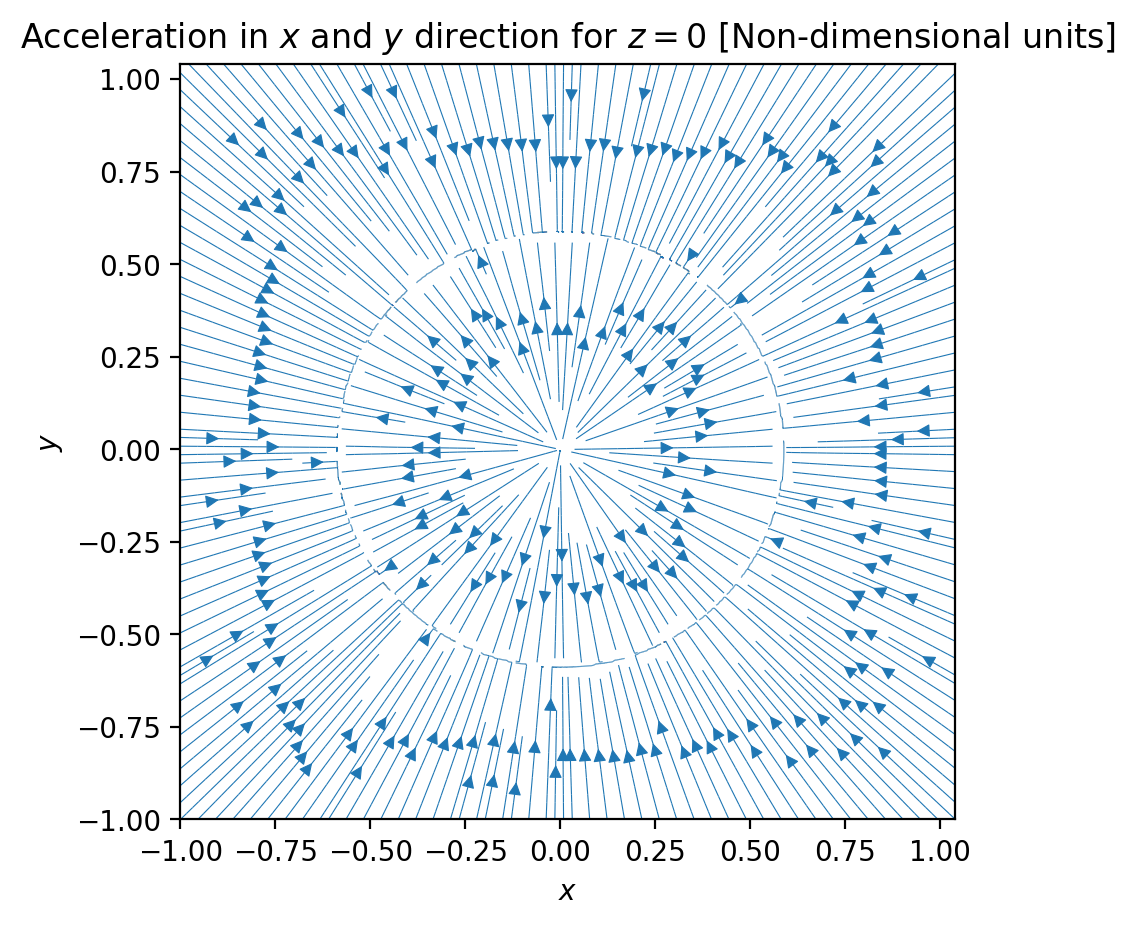

In [17]:
# We just want a slice of x, y values for z = 0
accelerations = np.array([i[1][:] for i in gravity_results])
accelerations = np.delete(accelerations, 2, 1)

# TODO: Ask why?
accelerations = -1 * accelerations


fig, ax = plt.subplots()

U = np.reshape(accelerations[:, 0], (len(X), -1))
V = np.reshape(accelerations[:, 1], (len(Y), -1))

# Quiver Plot the surface!!!! X <--> Y reversed! Investigate why?
# Streamplot --> X, Y ok, but V <--> U reversed?
plt.streamplot(X, Y, V, U, density=3, linewidth=0.4)

ax.set_title("Acceleration in $x$ and $y$ direction for $z=0$ [Non-dimensional units]")
ax.set_xlabel("$x$")
ax.set_ylabel("$y$")

fig.set_dpi(200)
fig.set_size_inches((5, 5))

plt.show()